# Garmin Statistics
## Heart rate and activities data analyses

In [473]:
%%pycodestyle
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
from shapely.geometry import LineString
from dotenv import load_dotenv
import garminexport
from garminconnect import (
    Garmin,
    GarminConnectConnectionError,
    GarminConnectTooManyRequestsError,
    GarminConnectAuthenticationError,
)

from datetime import timedelta, datetime as dt
from toai.imports import *
from toai.inpute import NumericInputer

In [472]:
%load_ext pycodestyle_magic

In [476]:
%%pycodestyle
load_dotenv()

MY_PSW = os.getenv('MY_PSW')
MY_EMAIL = os.getenv('MY_EMAIL')

6:1: W391 blank line at end of file


In [475]:
%%pycodestyle

try:
    client = Garmin(MY_EMAIL, MY_PSW)
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client init: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client init")
    quit()

15:1: W391 blank line at end of file


## Part 1: Getting the data

Data is colllected by using Garmin API for one user.

### Heart rate datasets

Heart rate is recorded every 2 minutes while Garmin watch is worn. If there is no signal, NaN values are generated. In addition to observed heart rates, some statistics as min, max and resting heart rates are provided. In the actual dataset some calendar dates are missing(24 hour without any observation). The heart rate dataset starts by 2019-08-31 and ends by 2020-07-20.


In [478]:
%%pycodestyle
d = [client.get_heart_rates(str(single_date.date())) for single_date in pd.date_range(start='2019-08-31', 
                                                                                      periods=400, freq='D')]
key1 = ('calendarDate', 'maxHeartRate', 'minHeartRate', 'restingHeartRate', 'lastSevenDaysAvgRestingHeartRate')
df_2 = pd.DataFrame(d)
df_3 = df_2.loc[:, key1]
df_3 = df_3.set_index('calendarDate')
df_3.head()

2:80: E501 line too long (105 > 79 characters)
2:106: W291 trailing whitespace
3:80: E501 line too long (109 > 79 characters)
4:80: E501 line too long (111 > 79 characters)
9:1: W391 blank line at end of file


In [484]:
heart_rate = pd.DataFrame()

for single_date in pd.date_range(start='2019-08-31', periods=400, freq='D'):
    try:
        d_temp = str(single_date.date())
        df_temp = pd.DataFrame.from_dict(client.get_heart_rates(d_temp)['heartRateValues'])
        df_temp['time'] = df_temp[0].apply(lambda x: datetime.fromtimestamp(x/1000).strftime("%H:%M:%S"))
        df_temp.set_index('time', inplace=True)
        df_temp = df_temp.drop(0, axis=1)
        df_temp.rename(columns={1: d_temp}, inplace=True)
        heart_rate = heart_rate.merge(df_temp, how='outer', left_index=True, right_index=True)
    except:
        single_date += timedelta(days=1)
      
heart_rate.head()

,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,...,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,75.0,NaN,NaN,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,52.0,57.0,NaN,49.0,77.0,99.0,86.0,42.0,65.0,72.0
00:00:00,75.0,NaN,NaN,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,52.0,57.0,NaN,49.0,77.0,99.0,86.0,42.0,65.0,72.0
00:00:00,75.0,NaN,NaN,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,52.0,57.0,NaN,49.0,77.0,99.0,86.0,42.0,65.0,72.0
00:00:00,75.0,NaN,NaN,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,52.0,57.0,NaN,49.0,77.0,99.0,86.0,42.0,65.0,72.0
00:00:00,75.0,NaN,NaN,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,52.0,57.0,NaN,49.0,77.0,99.0,86.0,42.0,65.0,72.0


In [16]:
heart_rate.to_csv('heart_rate_all.csv')
df_3.to_csv('heart_rate_stats.csv')

### Activities dataset
Activity is defined as sport activity recorded on Garmin watch. Mainly running activities are in the dataset. Some other types of activities are biking and open water swimming.

In [ ]:
pd.DataFrame(client.get_activities(1, 400)).to_csv('activity_test.csv')

## Part 2: Graphical data analyses

In [453]:
heart_rate_df = pd.read_csv('heart_rate_all.csv')
heart_rate_df = heart_rate_df.drop_duplicates(subset = 'time', keep = 'first').set_index('time').fillna(method='bfill', axis = 1)
heart_rate_df.head()

,2019-08-31,2019-09-01,2019-09-02,2019-09-03,2019-09-04,2019-09-05,2019-09-06,2019-09-07,2019-09-08,2019-09-09,...,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,75.0,71.0,71.0,71.0,62.0,56.0,56.0,56.0,99.0,55.0,...,72.0,72.0,58.0,68.0,67.0,72.0,96.0,53.0,77.0,NaN
00:02:00,70.0,71.0,77.0,77.0,62.0,58.0,55.0,58.0,96.0,55.0,...,72.0,72.0,58.0,67.0,65.0,72.0,96.0,52.0,78.0,NaN
00:04:00,72.0,70.0,66.0,66.0,62.0,58.0,55.0,61.0,88.0,56.0,...,71.0,71.0,58.0,66.0,67.0,74.0,82.0,60.0,77.0,NaN
00:06:00,80.0,72.0,60.0,60.0,58.0,57.0,56.0,59.0,78.0,56.0,...,73.0,73.0,58.0,63.0,62.0,79.0,83.0,60.0,78.0,NaN
00:08:00,73.0,97.0,54.0,54.0,55.0,57.0,56.0,59.0,69.0,56.0,...,72.0,72.0,57.0,64.0,64.0,69.0,101.0,64.0,79.0,NaN


In [384]:
activities_path = "activity_test.csv"
activities_df = pd.read_csv(activities_path, parse_dates = ['startTimeLocal', 'startTimeGMT'], index_col = 'Unnamed: 0')
activities_df.dropna(subset=['startLongitude', 'startLatitude'], inplace=True)

activities_df.head()

,activityId,activityName,description,startTimeLocal,startTimeGMT,activityType,eventType,comments,parentId,distance,...,splitSummaries,hasSplits,elevationCorrected,atpActivity,purposeful,favorite,pr,autoCalcCalories,parent,decoDive
0,5163882089,Vilnius Running,NaN,2020-06-29 20:04:13,2020-06-29 17:04:13,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,5724.700195,...,[],False,False,False,False,False,False,False,False,NaN
1,5151705793,Pastrevys Running,NaN,2020-06-27 11:37:17,2020-06-27 08:37:17,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,10063.629883,...,[],False,False,False,False,False,False,False,False,NaN
2,5148742644,Elektrenai Open Water Swimming,NaN,2020-06-26 19:52:44,2020-06-26 16:52:44,"{'typeId': 28, 'typeKey': 'open_water_swimming...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,31.990000,...,[],False,False,False,False,False,False,False,False,NaN
3,5148054776,Vilnius Cycling,NaN,2020-06-26 16:39:53,2020-06-26 13:39:53,"{'typeId': 2, 'typeKey': 'cycling', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,7262.879883,...,[],False,False,False,False,False,False,False,False,NaN
4,5148054686,Vilnius Running,NaN,2020-06-26 16:04:47,2020-06-26 13:04:47,"{'typeId': 1, 'typeKey': 'running', 'parentTyp...","{'typeId': 9, 'typeKey': 'uncategorized', 'sor...",NaN,NaN,5137.410156,...,[],False,False,False,False,False,False,False,False,NaN


In [452]:
activity_type = activities_df['activityType']
activity_type.dtype

dtype('O')

## Active and non-active days dataset
Active days are days, when sport activity is recorded, and the rest days are non-active.

In [365]:
active_days = activities_df['startTimeLocal'].dt.date.astype('str')
active_heart_rate = heart_rate_df.loc[:, heart_rate_df.columns.isin(active_days)]
active_heart_rate.head()

,2019-08-31,2019-09-01,2019-09-04,2019-09-08,2019-09-10,2019-09-11,2019-09-12,2019-09-16,2019-09-19,2019-09-21,...,2020-06-12,2020-06-14,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-26,2020-06-27,2020-06-29
time,,,,,,,,,,,,,,,,,,,,,
00:00:00,75.0,71.0,62.0,99.0,66.0,66.0,76.0,64.0,64.0,91.0,...,58.0,69.0,87.0,87.0,60.0,51.0,58.0,69.0,64.0,57.0
00:02:00,70.0,71.0,62.0,96.0,71.0,71.0,76.0,65.0,64.0,95.0,...,58.0,65.0,94.0,94.0,60.0,54.0,57.0,61.0,65.0,56.0
00:04:00,72.0,70.0,62.0,88.0,61.0,61.0,77.0,64.0,64.0,96.0,...,58.0,77.0,114.0,114.0,60.0,51.0,56.0,64.0,61.0,57.0
00:06:00,80.0,72.0,58.0,78.0,61.0,61.0,77.0,66.0,66.0,92.0,...,60.0,90.0,112.0,112.0,60.0,50.0,58.0,70.0,63.0,57.0
00:08:00,73.0,97.0,55.0,69.0,62.0,62.0,79.0,66.0,65.0,69.0,...,62.0,75.0,94.0,94.0,61.0,53.0,58.0,61.0,59.0,58.0


In [366]:
non_active_days = heart_rate_df.columns.difference(active_heart_rate.columns)
non_active_heart_rate = heart_rate_df.loc[:, heart_rate_df.columns.isin(non_active_days)]
non_active_heart_rate.iloc[45:50]

,2019-09-02,2019-09-03,2019-09-05,2019-09-06,2019-09-07,2019-09-09,2019-09-13,2019-09-14,2019-09-15,2019-09-17,...,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20
time,,,,,,,,,,,,,,,,,,,,,
01:30:00,52.0,52.0,58.0,56.0,61.0,52.0,76.0,61.0,62.0,67.0,...,68.0,68.0,56.0,60.0,70.0,71.0,60.0,53.0,76.0,NaN
01:32:00,53.0,53.0,58.0,57.0,62.0,53.0,76.0,63.0,61.0,69.0,...,70.0,70.0,57.0,62.0,71.0,69.0,59.0,53.0,77.0,NaN
01:34:00,53.0,53.0,59.0,58.0,64.0,54.0,76.0,64.0,60.0,69.0,...,68.0,68.0,57.0,61.0,70.0,70.0,58.0,54.0,78.0,NaN
01:36:00,56.0,56.0,59.0,58.0,63.0,54.0,76.0,63.0,61.0,69.0,...,69.0,69.0,58.0,62.0,70.0,70.0,59.0,55.0,79.0,NaN
01:38:00,58.0,58.0,59.0,59.0,64.0,54.0,77.0,61.0,61.0,69.0,...,69.0,69.0,56.0,62.0,72.0,71.0,60.0,56.0,80.0,NaN


## Histograms

Heart rate distribution comparision during active and non-active days.

<Figure size 432x288 with 0 Axes>

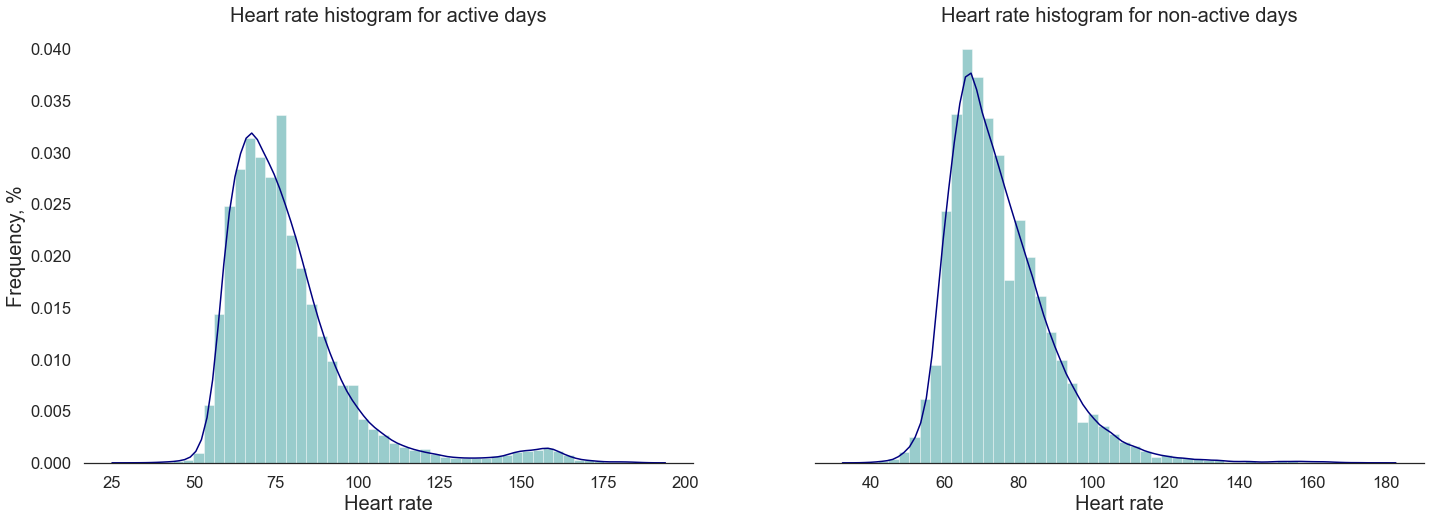

In [368]:
plt.figure()

fig, axis = plt.subplots(1, 2, figsize=(24, 8), sharey=True, frameon=False)
sns.despine(left=True)
axis[0].set_title('Heart rate histogram for active days', fontsize=20)
axis[1].set_title('Heart rate histogram for non-active days', fontsize=20)
axis[0].set_xlabel('Heart rate', fontsize=20)
axis[1].set_xlabel('Heart rate', fontsize=20)
axis[0].set_ylabel('Frequency, %', fontsize=20)

sns.distplot(active_heart_rate, hist_kws={'color': 'Teal'}, kde_kws={'color': 'Navy'}, ax = axis[0]);
sns.distplot(non_active_heart_rate, hist_kws={'color': 'Teal'}, kde_kws={'color': 'Navy'}, ax = axis[1]);
# for spine in plt.gca().spines.values():
#     spine.set_visible(False)
plt.tight_layout

plt.show()

## Plots

Min and max heart rates comparision

In [302]:
active_stats = active_heart_rate.describe()
non_active_stats = non_active_heart_rate.describe()
active_stats_t = active_stats.T
non_active_stats_t = non_active_stats.T

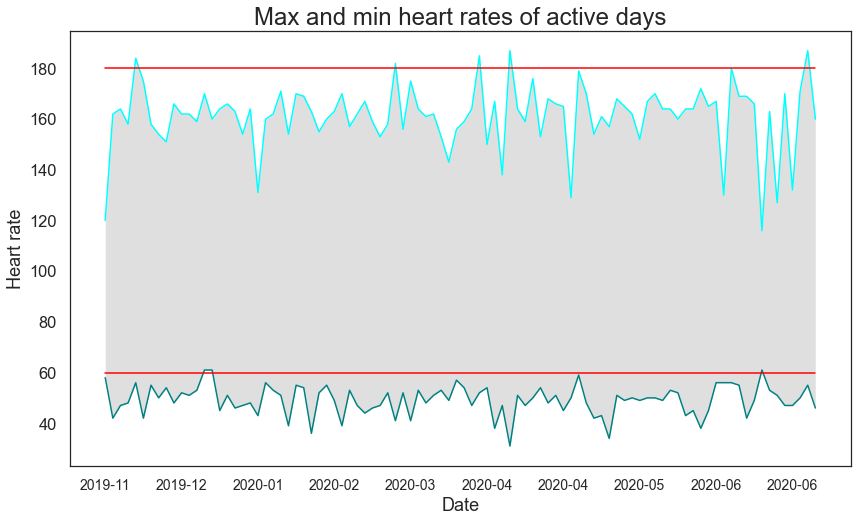

In [332]:
#labels to x axis
dates =  pd.DataFrame(list(active_stats.columns))
dates =  dates.iloc[:, 0].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

plt.figure(figsize = (14, 8))
plt.title('Max and min heart rates of active days', fontsize = 24)
plt.style.use('seaborn-pastel')

sns.lineplot(data = active_stats.loc['min'], color = 'Teal', ci = 'sh', markers = '-o')
sns.lineplot(data = active_stats.loc['max'], color = 'Cyan')
sns.lineplot(data = pd.Series([60]*len(active_stats.loc['min'])), color = 'Red')
sns.lineplot(data = pd.Series([180]*len(active_stats.loc['min'])), color = 'Red')

plt.gca().fill_between(range(len(active_stats.loc['min'])), 
                        active_stats.loc['min'], active_stats.loc['max'], 
                       facecolor='grey', 
                       alpha=0.25)
plt.legend = (['Min', 'Max'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Heart rate', fontsize = 18)
locs, labels = plt.xticks() 
plt.xticks(list(active_stats.columns)[0::10], dates.dt.to_period('M')[0::10], fontsize = 14)

plt.show()

## Boxplot

Min and max heart rates comparison by using boxplots

<Figure size 432x288 with 0 Axes>

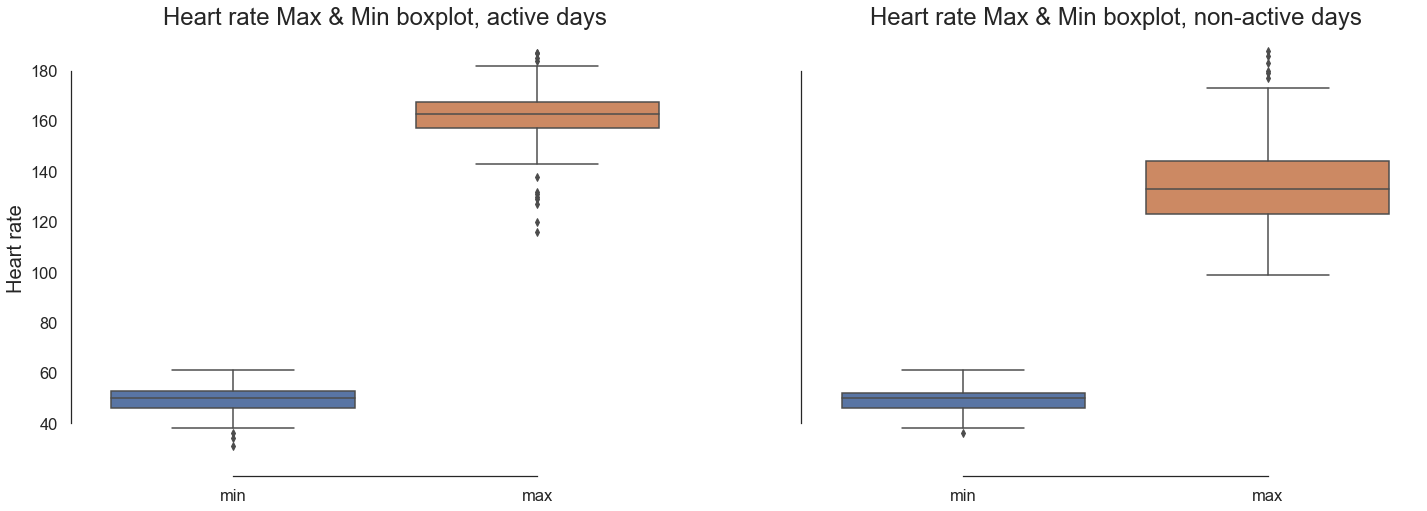

In [322]:
plt.figure()

sns.set(font_scale=1.5)
sns.set_style("white")

fig, axis = plt.subplots(1, 2, figsize=(24, 8), sharey=True, frameon=False)
axis[0].set_title('Heart rate Max & Min boxplot, active days', fontsize=24)
axis[1].set_title('Heart rate Max & Min boxplot, non-active days', fontsize=24)

sns.boxplot(x="variable", y="value", data=pd.melt(active_stats_t.loc[:,['min', 'max']]), ax = axis[0])
sns.boxplot(x="variable", y="value", data=pd.melt(non_active_stats_t.loc[:,['min', 'max']]), ax = axis[1])

sns.despine(offset=10, trim=True);
axis[0].set_xlabel('')
axis[1].set_xlabel('')
axis[0].set_ylabel('Heart rate', fontsize=20)
axis[1].set_ylabel('')

plt.show()

## Box plot

Activities summary

In [389]:
activities_df['month'] = activities_df['startTimeLocal'].dt.month_name()
activities_df['distance'] = activities_df['distance'].div(1000)

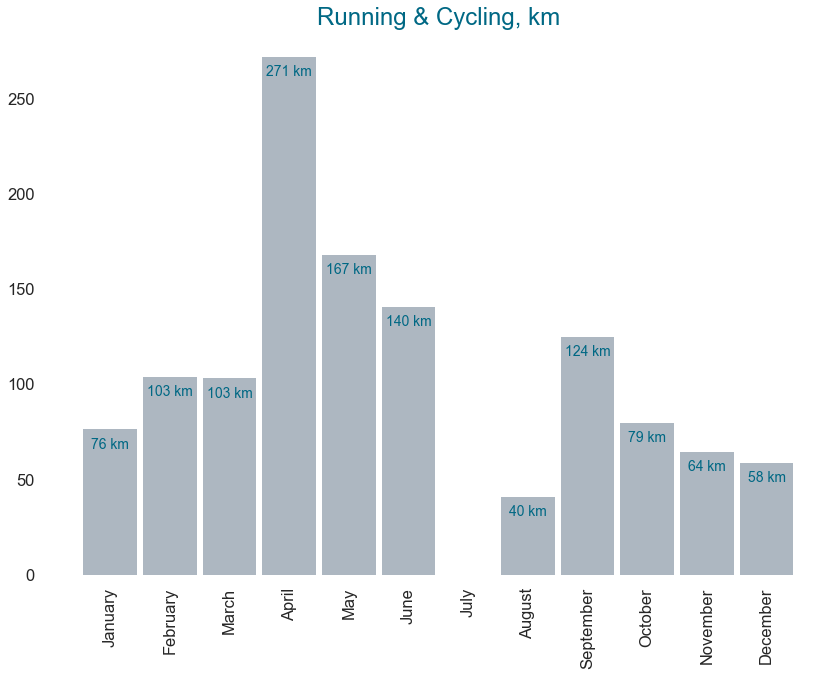

In [457]:
months = ['January','February','March','April','May','June','July','August',
          'September','October','November','December']
plt.figure(figsize = (14,10))
activities_df['month'] = pd.Categorical(activities_df['month'], categories=months, ordered=True)

bars = plt.bar(months, activities_df.groupby('month')['distance'].sum(), alpha=0.6, align='center', 
               width=0.9, linewidth=0, color='lightslategrey')
plt.title('Running & Cycling, km', fontsize = 24, color = '#006884')
plt.xticks(rotation = 90)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
   
list_1 = bars[:6]+bars[7:]
for bar in list_1:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height() - 10, str(int(bar.get_height())) + ' km', 
                 ha='center', color='#006884', fontsize=14)
plt.show()

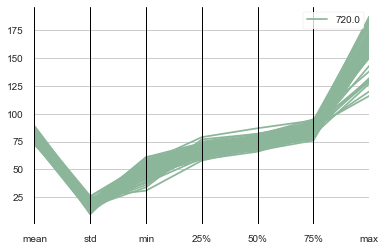

In [300]:
plt.figure()
pd.plotting.parallel_coordinates(active_stats2, 'count')

## Geo graphs

In [458]:
activities = gpd.GeoDataFrame(activities_df, geometry=gpd.points_from_xy(activities_df["startLongitude"], activities_df["startLatitude"]))

### Start place and quatity of sport activities 

In [459]:
import math
locations_map = folium.Map(location=[54.6872, 25.2797], tiles='cartodbpositron', zoom_start=13)

# Add points to the map
mc = MarkerCluster()
for idx, row in activities_df.iterrows():
    if not math.isnan(row['startLongitude']) and not math.isnan(row['startLatitude']):
        mc.add_child(Marker([row['startLatitude'], row['startLongitude']]))
locations_map.add_child(mc)

locations_map

### Heatmap of sport activities

In [461]:
sport_heatmap = folium.Map(location=[54.6872, 25.2797], tiles='cartodbpositron', zoom_start=8)
HeatMap(data=activities_df[['startLatitude','startLongitude']], radius=10).add_to(sport_heatmap)

sport_heatmap